In [4]:
#Importations utiles liés à la gestion des données
import pandas as pd
from scipy import sparse
from scipy import linalg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score,RocCurveDisplay,roc_curve, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook as tq
import pickle

In [5]:
def fp_from_fp_db(fp_db):
    '''
    Cette fonction permet de recréer le fingerprint de taille 2048
    à partir du fingerprint codé en mémoire
    '''
    res = np.zeros(2048)
    #On initialise un array de 2048 zéros
    list_idx = fp_db.split(" ")
    #On récupère tous les indices non nuls du fingerprint
    for el in list_idx[:-1]:
        lfp = el.split("-")
        n = len(lfp)
        #En fonction des cas, on complète avec la bonne valeur
        if n == 1:
            res[int(lfp[0])] = 1
        elif n==2:
            res[int(lfp[0])] = int(lfp[-1])
        else:
            res[int(lfp[0])] = -int(lfp[-1])
    return res

def input_model_from_db(base_fp):
    '''
    Cette fonction renvoie un array de fingerprint à partir d'un dataset contenant des
    fingerprints sous forme "codée"
    '''
    #On sépare fingerprint de réactions et fingerprints du produit
    prod_fp_db,rxn_fp_db = base_fp["Product_Fingerprint"],base_fp["Reaction_Fingerprint"]
    prod_fp,rxn_fp = [],[]
    p_bar = tq.tqdm(total=base_fp.shape[0])
    for i in range(base_fp.shape[0]):
        #On essaie de récupérer le fingerprint associé à la ligne i
        try:
            p_bar.update(1)
            rxn_fp.append(fp_from_fp_db(rxn_fp_db.iloc[i]))
            prod_fp.append(fp_from_fp_db(prod_fp_db.iloc[i]))
        except:
            continue
    return np.array(prod_fp), np.array(rxn_fp)

In [3]:
#Nom des fichiers nécessaires
fname_fp_false = "NOM DU FICHIER CONTENANT LES FAUSSES REACTIONS SUR LESQUELLES S'ENTRAINER"
fname_fp_true = "NOM DU FICHIER CONTENANT LES VRAIES  REACTIONS SUR LESQUELLES S'ENTRAINER"

In [6]:
#On récupère les bases de données associées aux noms des fichiers
data_fp_false = pd.read_csv(fname_fp_false)
data_fp_true = pd.read_csv(fname_fp_true)

In [7]:
#On récupère la taille des données
size_true = data_fp_true.shape[0]
size_false = data_fp_false.shape[0]

In [8]:
#On convertit les données en fingerprint 
#On tronque pour ne pas saturer la RAM
troncature = 100000
#On récupère les produits et les réactions correspondantes sous forme de fingerprint
p1,p2 = input_model_from_db(data_fp_true[:troncature])

  0%|          | 0/100000 [00:00<?, ?it/s]

In [9]:
#On récupère les produits et les réactions correspondantes sous forme de fingerprint pour la base de données fausses
#Dans le but de ne pas induire un biais, on garde la même proportion de données vraies et fausses
#Nous avons essayé de shuffle les données avant et d'entraîner notre modèle mais cela n'a pas donné de 
#différences notables 
#Nous avons donc gardé la version la plus simple
p3,p4 = input_model_from_db(data_fp_false[:size_false*troncature//size_true])

  0%|          | 0/13867 [00:00<?, ?it/s]

In [10]:
#Array des Fingerprints des Produits liés aux Vraies Reactions et Fausses Reactions
prod_fp = np.concatenate((p1, p3))

In [11]:
#Array des Fingerprints des Réactions liés aux Vraies Reactions et Fausses Reactions
rxn_fp = np.concatenate((p2,p4))

In [12]:
#Labels : 1 pour les vraies réactions, 0 pour les fausses
labels = np.array([1]*p1.shape[0]+[0]*p3.shape[0])

In [13]:
#On concatène notre data en input ici sous la
data_input = [np.concatenate((rxn_fp[i], prod_fp[i])) for i in range(rxn_fp.shape[0])]

In [14]:
#### PARAMETRES : proportion d'entraînement
train_prop = 0.9
test_prop  = 0.1

In [15]:
#On divise les données de façon aléatoire : on utilise le random_state 42 pour avoir des résultats reproductibles
input_train, input_test, labels_train, labels_test = train_test_split(data_input, labels, train_size = train_prop, random_state=42)

## Entrainement du modèle

In [16]:
#On crée notre modèle
log_regression_alg = LogisticRegression()

In [17]:
#On l'entraîne
log_regression_alg.fit(input_train, labels_train)

C:\Users\Yassine\anaconda3\envs\aizynth-env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [23]:
#Saving the Model
filename = 'regression_model.sav'
pickle.dump(log_regression_alg, open(filename, 'wb'))

## Premiers Résultats

In [64]:
#On prédit sur les données de test
y_pred = log_regression_alg.predict_proba(input_test)

In [ ]:
#On calcule précision, recall, fscore
precision, recall, fscore, support = score(labels_test, y_pred, pos_label=1, average='binary')

In [66]:
precision,recall,fscore

(0.9573728772084373, 0.9789320922784367, 0.9680324623911322)

In [67]:
def plot_roc_curve_from_res(fpr,tpr,thresholds):
    '''
    Permet d'afficher la courbe ROC
    '''
    plt.plot(fpr,tpr)
    plt.xlabel("taux de faux positifs")
    plt.ylabel("taux de vrais positifs")

    plt.show()

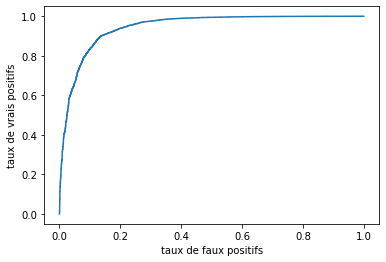

0.9443100801431126

In [69]:
fpr, tpr, thresholds = roc_curve(labels_test, y_pred[:,1])
plot_roc_curve_from_res(fpr,tpr,thresholds)
roc_auc_score(labels_test, y_pred[:,1])